# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)
- Switching between variants of fixed key / random key traces (TODO)

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np

from tools.cache import cache_np
from tools.traceloader import ASCAD, TraceGroup

sns.set_style("whitegrid")

In [19]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [20]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

In [64]:
from data.loader.ascad import ASCADData

print(ASCADData.random_key()["Profiling_traces"]['labels'][0])
ASCADData.random_key()["Profiling_traces"]['metadata'][0][1][2]

125


173

<AxesSubplot:>

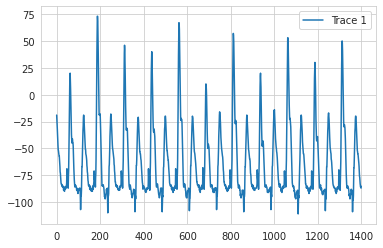

In [21]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

### Plot of a small section of two traces

<AxesSubplot:>

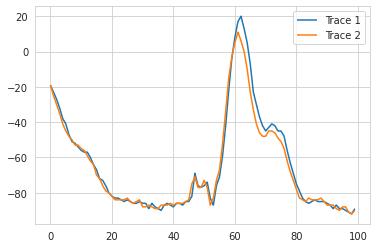

In [22]:
T2 = ascad.default.profile.traces[1]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

<AxesSubplot:>

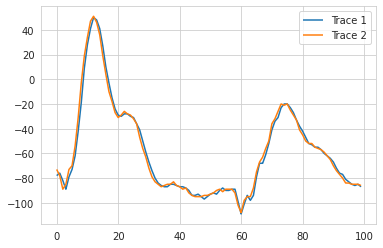

In [23]:
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[-100:], columns=["Trace 1", "Trace 2"]))

### Mean of ASCAD traces.

In [24]:
print(f"Profiling trace mean: {ascad.default.profile.traces.mean():.2f},\n"
      f"Attack trace mean: {ascad.default.attack.traces.mean():.2f}")

Profiling trace mean: -63.59,
Attack trace mean: -63.67


### Variance of ASCAD traces.

In [25]:
print(f"Profiling trace variance: {ascad.default.profile.traces.var():.2f},\n"
      f"Attack trace variance: {ascad.default.attack.traces.var():.2f}")

Profiling trace variance: 1149.78,
Attack trace variance: 1138.65


### Mean and variance between all traces.

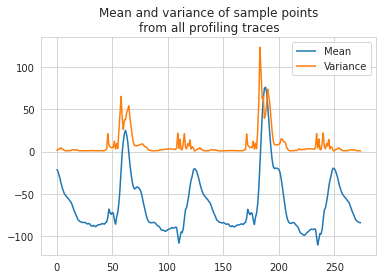

In [26]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

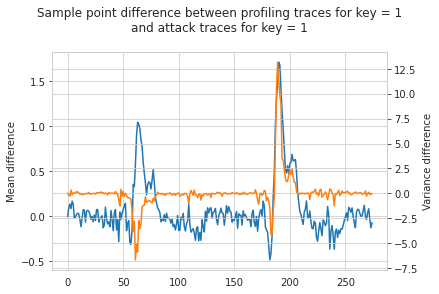

In [27]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


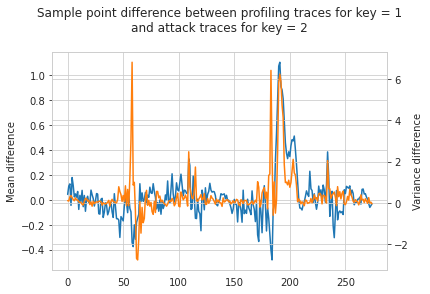

In [28]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

# Finding Points of Interest

In [29]:
from scipy import stats

### Order difference detection tool

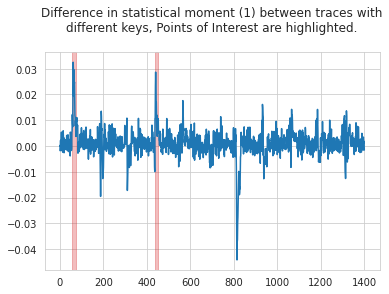

In [30]:
def calc_moment_difference(tg: TraceGroup, moment=1, use_attack=False):
    kr = range(ASCAD.key_size)
    stat_moment = lambda a: stats.moment(a, moment=moment, axis=0, nan_policy='raise')

    if use_attack:
        left = [stat_moment(tg.profile.filter_traces(k)) for k in kr]
        right = [stat_moment(tg.attack.filter_traces(k)) for k in kr]
    else:
        left, right = [], []
        tc = tg.profile

        for k in kr:
            traces = tc.filter_traces(k)
            mid = round(len(traces) / 2)
            left.append(stat_moment(traces[mid:]))
            right.append(stat_moment(traces[:mid]))

    dist_neq = [abs(left[i] - right[j]) for i in kr for j in kr if i != j]
    dist_eq = [abs(left[i] - right[i]) for i in kr]

    return np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0)

def get_moment_differences(db, use_attack=False, trace_size=ASCAD.trace_len, max_moment=3):
    mdiff = [calc_moment_difference(db.default, i, use_attack) for i in range(1, max_moment + 1)]

    return np.array([np.zeros(trace_size), *mdiff])

MOMENT_DIFFERENCES = cache_np("moment_differences", get_moment_differences, ascad, v=4)
TRUE_MDIFF = cache_np("true_moment_differences", get_moment_differences, ascad, True, v=4)

# TODO try window = 100, strange result.
def select_poi(diff, window=15):
    """
    Selects the top n most interesting points of interest, based on some statistical moment difference.
    """
    std = np.std(diff)
    # We are only interested in large distances between sample points in non-equal keys and
    #   small distances in sample points between equal keys.
    ts = [*(diff > std), *([False] * window)]

    acc = []
    counter, sum_diff, max_diff = 0, 0.0, 0.0
    for ix in range(len(ts)):
        if ts[ix]:
            counter += 1
            sum_diff += diff[ix]
            max_diff = max(diff[ix], max_diff)

        elif counter >= window:
            avg_diff = sum_diff / counter

            if avg_diff > 2 * std:
                acc.append((ix - counter, ix, avg_diff))

            counter, sum_diff, max_diff = 0, 0.0, 0.0

    if len(acc) == 0:
        return []

    return pd.DataFrame(acc).sort_values(2, ascending=False)[[0,1]].values

def plot_poi(mdiff, moment):
    fig, ax = plt.subplots()

    title = f"Difference in statistical moment ({moment}) between traces with\n" \
            f"different keys, Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment]):
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

def plot_poi_trace(trace, poi):
    fig, ax = plt.subplots()

    title = f"Some power trace, Points of Interest are highlighted.\n"
    sns.lineplot(data=trace, palette=[sns.color_palette()[4]]).set_title(title)

    for a, b in poi:
        ax.axvspan(a, b, alpha=0.3, color=sns.color_palette()[3])

    plt.show()

plot_poi(MOMENT_DIFFERENCES, 1)

#### Points of interest

In [31]:
select_poi(MOMENT_DIFFERENCES[1])

array([[ 54,  74],
       [436, 453]])

#### Points of interest with power trace

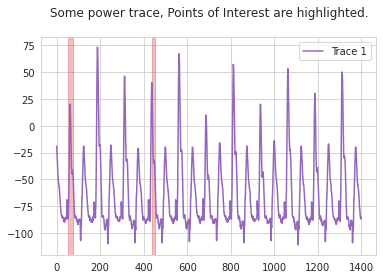

In [32]:
plot_poi_trace(pd.DataFrame(T1, columns=["Trace 1"]), select_poi(MOMENT_DIFFERENCES[1]))

### PoI for the variance

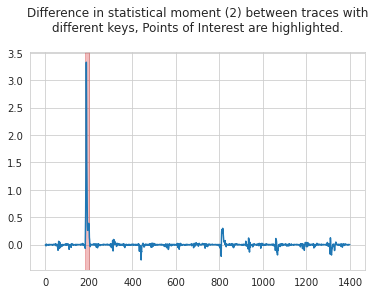

In [33]:
plot_poi(MOMENT_DIFFERENCES, 2)

### PoI for the skewness

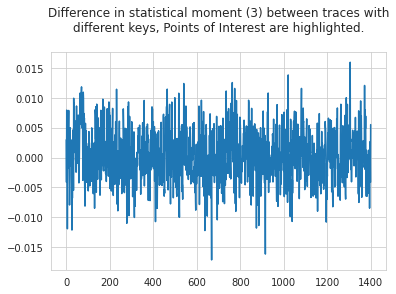

In [34]:
plot_poi(MOMENT_DIFFERENCES, 3)